# Stage 7: Outliers + Risk Assumptions
Preprocessing Part II — Applied Financial Engineering Lifecycle (Aug 19, Tue)

**Objectives**
- Detect outliers (IQR, Z-score)
- Handle outliers (remove, winsorize)
- Run a simple sensitivity analysis and document assumptions

In [ ]:
# 1) Setup
import numpy as np
import pandas as pd

# Library for Data visualization
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# 2) Create a sample dataset with outliers
np.random.seed(7)
x = np.linspace(0, 10, 60)
y = 1.8 * x + 0.5 + np.random.normal(0, 1.8, size=x.size)
# Inject a few extreme points
y[8] += 20
y[25] -= 18
y[47] += 15
df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0.000000,3.542946
1,0.169492,-0.033603
2,0.338983,1.169246
3,0.508475,2.148784
4,0.677966,0.300278


## 2) Quick Visual Check

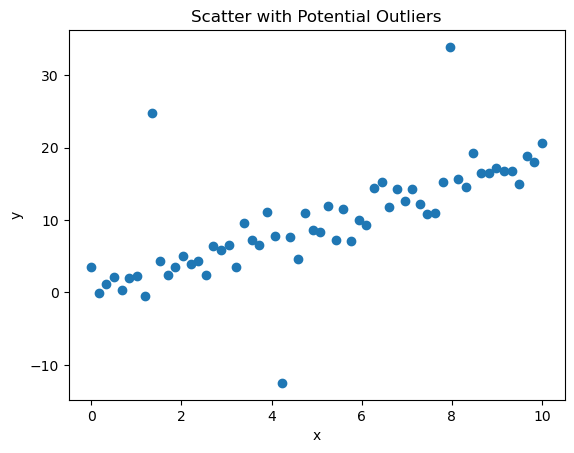

In [ ]:
# Visualize potential outliers
plt.figure()
plt.scatter(df['x'], df['y'])
plt.title('Scatter with Potential Outliers')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## 3) Detecting Outliers — IQR
**Idea:** Flag points outside Q1 − 1.5·IQR and Q3 + 1.5·IQR.

In [6]:
# Function to detect outliers using IQR (IQR is Interquartile Range)
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask where True indicates an outlier by IQR rule.
    Parameters
    ----------
    series : pd.Series
        Numeric series to evaluate.
    k : float
        Multiplier for IQR to set fences (default 1.5).
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

df['outlier_iqr'] = detect_outliers_iqr(df['y'])
df['outlier_iqr'].value_counts()

outlier_iqr
False    58
True      2
Name: count, dtype: int64

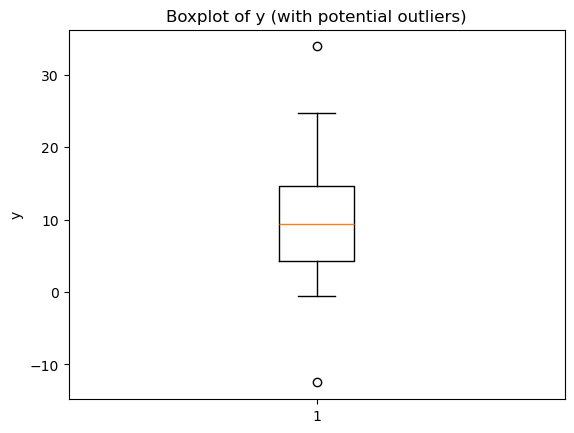

In [7]:
# Visualize potential outliers with boxplot template
plt.figure()
plt.boxplot(df['y'], vert=True)
plt.title('Boxplot of y (with potential outliers)')
plt.ylabel('y')
plt.show()

## 4) Detecting Outliers — Z-score
**Idea:** Flag points where |z| > threshold (commonly 3).
Note: Z-score assumes approximate normality; heavy tails may cause over-flagging.

In [ ]:
#detect outliers using z-score
def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask where True indicates |z| > threshold."""
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

df['outlier_z'] = detect_outliers_zscore(df['y'], threshold=3.0)
pd.crosstab(df['outlier_iqr'], df['outlier_z'])

outlier_z,False,True
outlier_iqr,,
False,58,0
True,0,2


## 5) Handling Options
We will compare three treatments: **All data**, **Filtered (remove IQR outliers)**, and **Winsorized** (optional).

In [ ]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    """Return a winsorized copy of the series, clipping to given quantiles."""
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

df_filtered = df.loc[~df['outlier_iqr'], ['x', 'y']].reset_index(drop=True)
df_w = df.copy()
df_w['y_w'] = winsorize_series(df_w['y'], lower=0.05, upper=0.95)

In [ ]:
plt.figure()
plt.hist(df['y'], bins=20, alpha=0.7)
plt.title('Histogram of y (original)')
plt.xlabel('y')
plt.ylabel('count')
plt.show()

plt.figure()
plt.hist(df_w['y_w'], bins=20, alpha=0.7)
plt.title('Histogram of y (winsorized)')
plt.xlabel('y_w')
plt.ylabel('count')
plt.show()

## 6) Sensitivity Analysis — Linear Regression
We compare slope, intercept, R², and MAE across treatments.

In [ ]:
def fit_and_metrics(X: np.ndarray, y: np.ndarray) -> dict:
    model = LinearRegression()
    model.fit(X, y)
    y_hat = model.predict(X)
    return {
        'slope': float(model.coef_[0]),
        'intercept': float(model.intercept_),
        'r2': float(r2_score(y, y_hat)),
        'mae': float(mean_absolute_error(y, y_hat))
    }

# All data
m_all = fit_and_metrics(df[['x']].to_numpy(), df['y'].to_numpy())
# Filtered (no IQR outliers)
m_flt = fit_and_metrics(df_filtered[['x']].to_numpy(), df_filtered['y'].to_numpy())
# Winsorized
m_win = fit_and_metrics(df[['x']].to_numpy(), df_w['y_w'].to_numpy())

sens_table = pd.DataFrame([m_all, m_flt, m_win], index=['all', 'filtered_iqr', 'winsorized'])
sens_table

In [ ]:
plt.figure()
plt.scatter(df['x'], df['y'], label='all')
x_line = np.linspace(df['x'].min(), df['x'].max(), 100).reshape(-1,1)
def line(slope, intercept):
    return slope * x_line[:,0] + intercept
plt.plot(x_line, line(m_all['slope'], m_all['intercept']), label='fit: all')
plt.plot(x_line, line(m_flt['slope'], m_flt['intercept']), label='fit: filtered')
plt.plot(x_line, line(m_win['slope'], m_win['intercept']), label='fit: winsorized')
plt.legend()
plt.title('Regression Fits Across Treatments')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Save Sensitivity Table (Reproducibility)

In [ ]:
sens_table.to_csv('sens_stage07_demo.csv', index=True)
sens_table

## 7) Document Assumptions & Risks
- IQR multiplier k=1.5; Z threshold=3.0; winsor quantiles 5%/95%.
- Data may be heavy-tailed; Z-score may over-flag.
- Removing outliers may discard rare but meaningful events (e.g., crash days).
- Always report thresholds and provide results **with and without** outliers.

## 8) Wrap-Up
**Takeaways**
- Outlier definitions and treatments are **assumption-dependent**.
- Test sensitivity; compare multiple treatments.
- Document decisions for reproducibility.